In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import plt
import yfinance as yf
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

plt.style.use('seaborn')
%matplotlib inline

/Users/hejifan/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/hejifan/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
<ipython-input-1-88042f73e2a0>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Preliminary Data Processing

In [2]:
# Russell 2000 and S&P 400 
russell_df = yf.download('^RUT', start = '1900-01-01', end = '2023-01-18', progress = False)
sp400_df = yf.download('^SP400', start = '1900-01-01', end = '2023-01-18', progress = False)

In [3]:
russell_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1987-09-10,167.440002,168.979996,167.440002,168.970001,168.970001,179800000
1987-09-11,168.970001,170.539993,168.750000,170.539993,170.539993,178000000
1987-09-14,170.529999,170.949997,170.149994,170.429993,170.429993,154400000
1987-09-15,170.419998,170.440002,169.130005,169.199997,169.199997,136200000
1987-09-16,169.309998,170.029999,168.820007,168.919998,168.919998,195700000
...,...,...,...,...,...,...
2023-01-10,1794.290039,1822.650024,1793.189941,1822.650024,1822.650024,3851030000
2023-01-11,1827.119995,1844.160034,1826.520020,1844.050049,1844.050049,4303360000
2023-01-12,1850.250000,1876.060059,1839.089966,1876.060059,1876.060059,4440260000


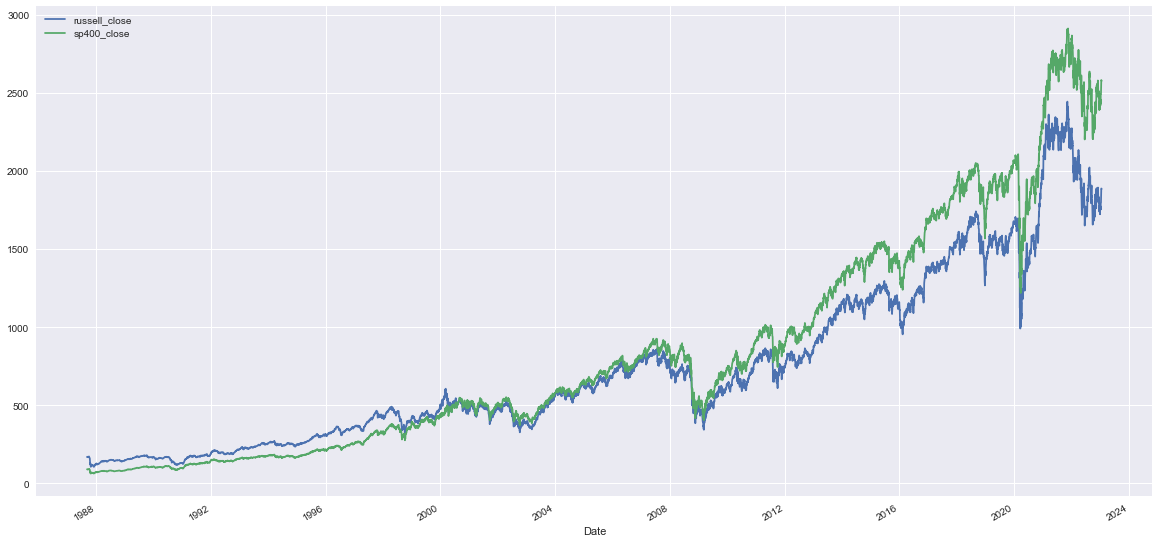

In [4]:
russell = russell_df[['Close']]
Russell = russell.rename(columns = {'Close': 'russell_close'})

sp400 = sp400_df[['Close']]
Sp400 = sp400.rename(columns = {'Close': 'sp400_close'})

prices = pd.concat([Russell, Sp400], axis = 1)
df_index = prices.dropna()
df_index.plot(figsize=(20,10));

## 2. Cointegration Tests: Engle Granger Two-Step Procedure

**Engle Granger Two-Step Procedure**: step 1: Estimate the cointegration relationship

In [5]:
baseline_regression_model = ols('sp400_close ~ russell_close', data = df_index).fit()

In [6]:
beta_0 = baseline_regression_model.params[0]
beta_1 = baseline_regression_model.params[1]

In [7]:
print(baseline_regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:            sp400_close   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.194e+06
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        12:04:40   Log-Likelihood:                -49287.
No. Observations:                8909   AIC:                         9.858e+04
Df Residuals:                    8907   BIC:                         9.859e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -137.5795      1.101   -125.003

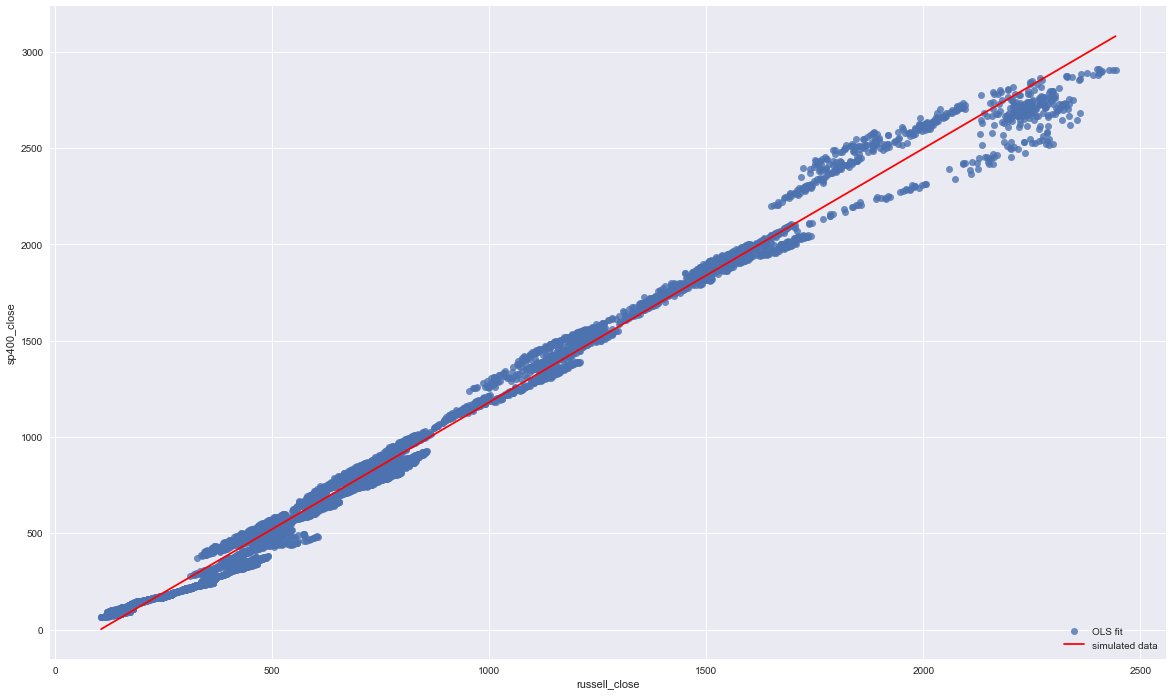

In [8]:
x = np.linspace(df_index['russell_close'].min(), df_index['russell_close'].max(),1000)
y_hat = beta_0 + beta_1 * x

ax = sns.regplot(x = df_index['russell_close'], y = df_index['sp400_close'], fit_reg = False)
ax.plot(x, y_hat, 'r')
ax.figure.set_size_inches(20,12)
plt.legend(['OLS fit', 'simulated data'], loc = 'lower right')

step 2: Test for stationarity of the residual

In [9]:
from statsmodels.tsa.stattools import adfuller
def testStationary(data):
    adftest = adfuller(data)
    result = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key,value in adftest[4].items():
        result['Critical Value(%s)' % key] = value
    result = pd.DataFrame(result)
    return result

In [10]:
coint_residual = df_index['sp400_close'] - beta_0 - beta_1 * df_index['russell_close']
adf_test_result = testStationary(coint_residual)
new_col = ['sp400_close & russell_close']
adf_test_result.columns = new_col
adf_test_result = adf_test_result.T
adf_test_result

,Test Statistic,p-value,Lags Used,Number of Observations Used,Critical Value(1%),Critical Value(5%),Critical Value(10%)
sp400_close & russell_close,-3.559751,0.006579,35.0,8873.0,-3.431087,-2.861866,-2.566943


So, p_value < 0.05. So, there is sufficient evidence for us to believe that the two stocks cointergate with each other.

In [11]:
float(adf_test_result['p-value'])

0.006578807121109794

**Johhansen Cointegration Test**

In [12]:
jers = coint_johansen(df_index, det_order=0, k_ar_diff=1)

In [13]:
jers.trace_stat

array([17.80529447,  0.14318915])

In [14]:
jers.trace_stat_crit_vals

array([[13.4294, 15.4943, 19.9349],
       [ 2.7055,  3.8415,  6.6349]])

In [15]:
jers.max_eig_stat

array([17.66210532,  0.14318915])

In [16]:
jers.max_eig_stat_crit_vals

array([[12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

## 3. Trading Strategy 

In [17]:
mu_e = coint_residual.mean()
sigma_e = coint_residual.std()

Z = 0.8
bounds_high = mu_e + sigma_e * Z
bounds_low = mu_e - sigma_e * Z

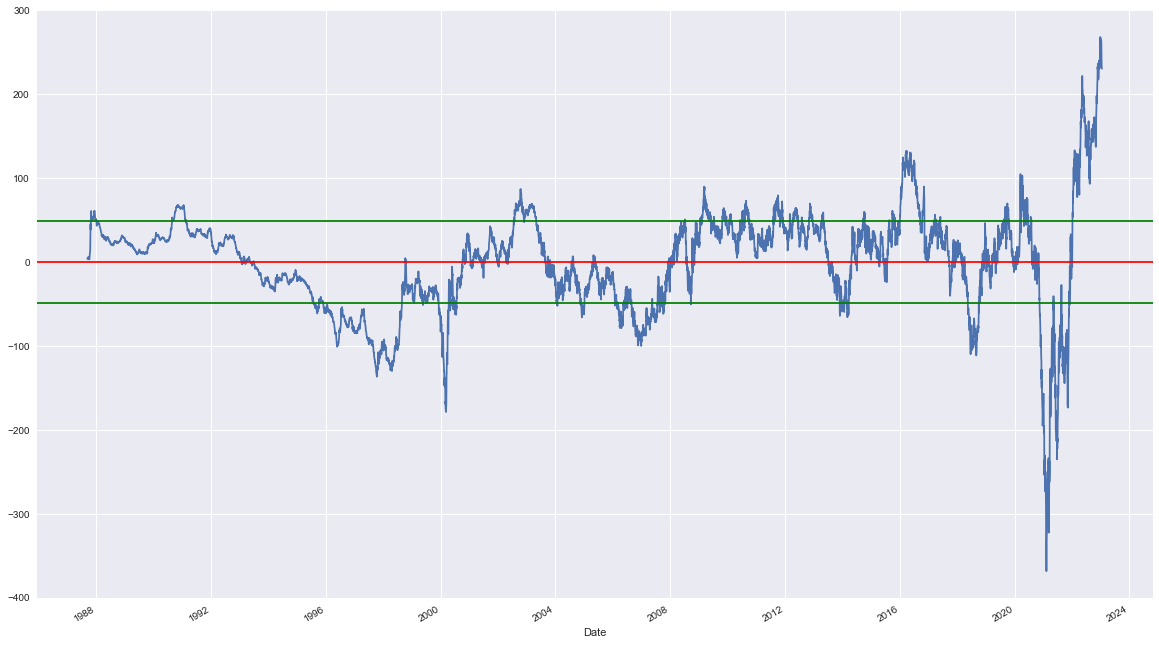

In [18]:
coint_residual.plot(figsize = (20,12))
plt.axhline(mu_e, color = 'red', linestyle = '-')
plt.axhline(bounds_high, color = 'green', linestyle = '-')
plt.axhline(bounds_low, color = 'green', linestyle = '-')

产生交易信号

In [19]:
result_data = pd.DataFrame(coint_residual, columns = ['coint_residual'])

In [20]:
S = 0.3
result_data['position_1'] = np.where(result_data['coint_residual'] > bounds_high, 1, np.nan)
result_data['position_1'] = np.where(result_data['coint_residual'] < bounds_low, -1, result_data['position_1'])
result_data['position_1'] = np.where(abs((result_data['coint_residual'] - mu_e) / sigma_e) < S, 0, result_data['position_1'])
result_data['position_1'] = result_data['position_1'].fillna(method='ffill')
result_data['position_2'] = - np.sign(result_data['position_1'])

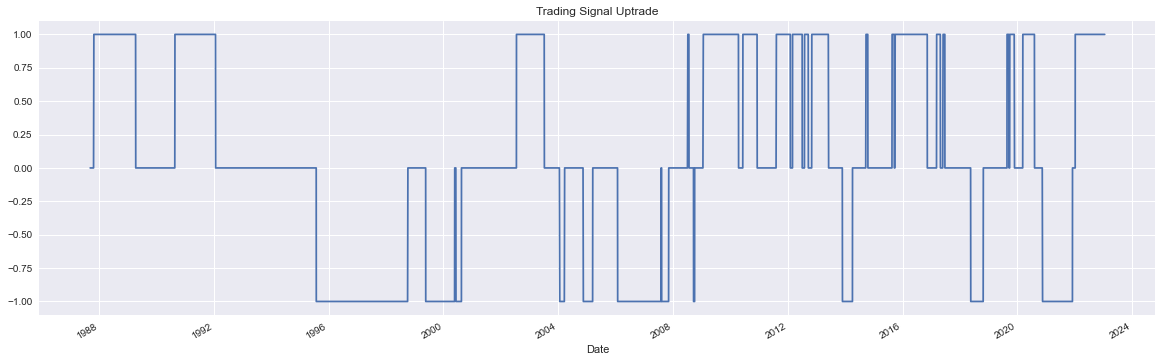

In [21]:
result_data['position_1'].plot(ylim = [-1.1, 1.1], figsize = (20,6), title = 'Trading Signal Uptrade');

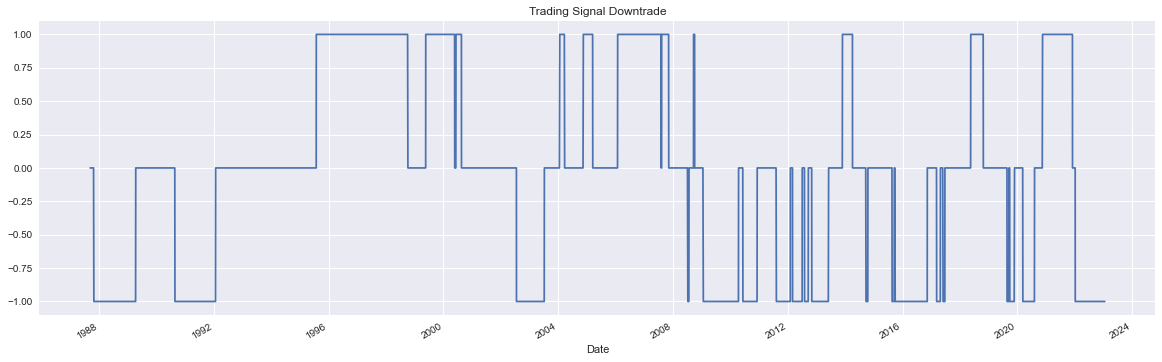

In [22]:
result_data['position_2'].plot(ylim = [-1.1, 1.1], figsize = (20,6), title = 'Trading Signal Downtrade');

Backtesting

In [23]:
# Method 1: Log returns
result_data['returns_1'] = np.log(df_index['russell_close'] / df_index['russell_close'].shift(1))
result_data['returns_2'] = np.log(df_index['sp400_close'] / df_index['sp400_close'].shift(1))
weight = beta_1 / (1+beta_1)
result_data['strategy'] = weight * (result_data['position_1'].shift(1) * result_data['returns_1']) + (1-weight) * (result_data['position_2'].shift(1) * result_data['returns_2'])

<AxesSubplot: title={'center': 'Cumulative Return'}, xlabel='Date'>

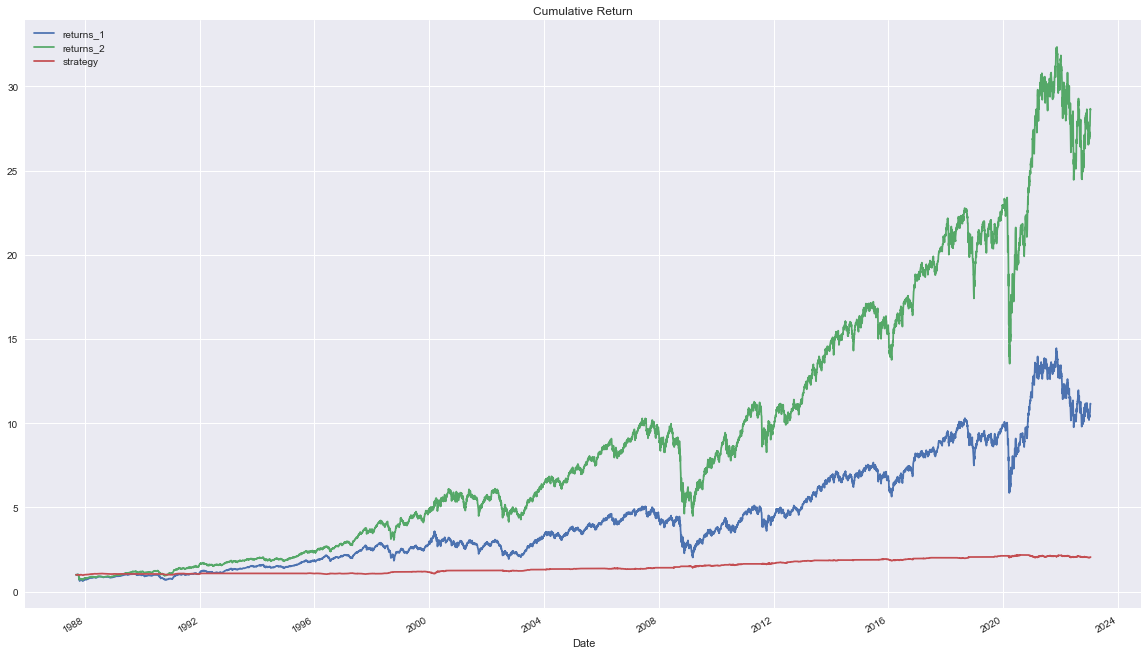

In [24]:
result_data[['returns_1', 'returns_2', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(20,12), title = 'Cumulative Return')

In [25]:
# Method 2: Simple returns
returns_1 = df_index['russell_close'].pct_change().dropna()
returns_2 = df_index['sp400_close'].pct_change().dropna()

weight = beta_1 / (1+beta_1)

strategy = weight * (result_data['position_1'].shift(1) * returns_1) + (1-weight) * (result_data['position_2'].shift(1) * returns_2)

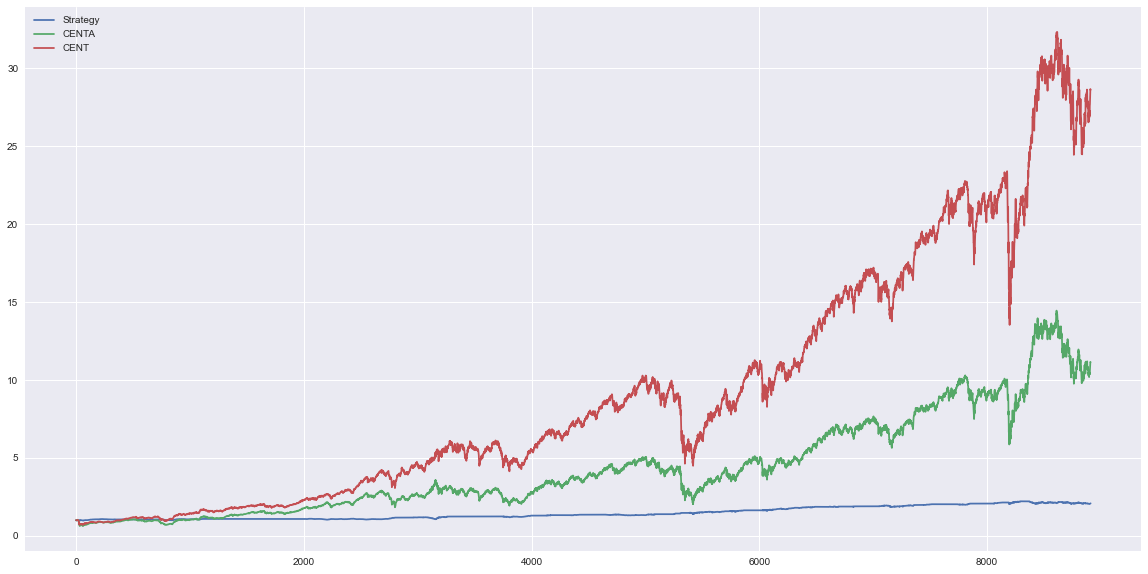

In [26]:
plt.figure(figsize=(20,10))
plt.plot(np.nancumprod(strategy + 1), label='Strategy')
plt.plot(np.nancumprod(returns_1 + 1), label='CENTA')
plt.plot(np.nancumprod(returns_2 + 1), label='CENT')

plt.legend()